# Metrics for uncertainty evaluation in regression problems


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
# plt.style.use('seaborn')
plt.rcParams['font.size'] = 18
import seaborn as sns

In [10]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [11]:
from scipy import stats
from scipy.stats.mstats import mquantiles

from plotnine import *

In [12]:
import lightgbm as lgb

In [14]:
from ngboost import ngboost # NGBoost
from ngboost import learners # default_tree_learner
from ngboost import distns # Normal
from ngboost import scores # MLE

In [26]:
import tensorflow as tf


import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors


# from tensorflow.keras import layers # Input, Dense, Concatenate
# from tensorflow.keras import models # Model

import tensorflow as tf

from tensorflow.python.keras import *

# np.random.seed(42)
# tf.random.set_seed(42)


In [27]:
#CRPS score
import properscoring as ps

In [28]:
from sklearn.datasets import fetch_california_housing

## Data

In [29]:
california_housing = fetch_california_housing(as_frame=True)

In [30]:
data = california_housing.frame

In [31]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.32520,41.00000,6.98413,1.02381,322.00000,2.55556,37.88000,-122.23000,4.52600
1,8.30140,21.00000,6.23814,0.97188,2401.00000,2.10984,37.86000,-122.22000,3.58500
2,7.25740,52.00000,8.28814,1.07345,496.00000,2.80226,37.85000,-122.24000,3.52100
3,5.64310,52.00000,5.81735,1.07306,558.00000,2.54795,37.85000,-122.25000,3.41300
4,3.84620,52.00000,6.28185,1.08108,565.00000,2.18147,37.85000,-122.25000,3.42200
...,...,...,...,...,...,...,...,...,...
20635,1.56030,25.00000,5.04545,1.13333,845.00000,2.56061,39.48000,-121.09000,0.78100
20636,2.55680,18.00000,6.11404,1.31579,356.00000,3.12281,39.49000,-121.21000,0.77100
20637,1.70000,17.00000,5.20554,1.12009,1007.00000,2.32564,39.43000,-121.22000,0.92300
20638,1.86720,18.00000,5.32951,1.17192,741.00000,2.12321,39.43000,-121.32000,0.84700


In [32]:
target = california_housing.target

In [33]:
target

0       4.52600
1       3.58500
2       3.52100
3       3.41300
4       3.42200
          ...  
20635   0.78100
20636   0.77100
20637   0.92300
20638   0.84700
20639   0.89400
Name: MedHouseVal, Length: 20640, dtype: float64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, shuffle=True)

In [35]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((16512, 9), (16512,), (4128, 9), (4128,))

## Quantile Regression

In [36]:
quantiles = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]

quantile_predictions = {}

In [37]:
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)

In [38]:
params = {'objective': 'regression'}
lgb_model = lgb.train(params=params, train_set=train_data, num_boost_round=100)
lgb_prediction = lgb_model.predict(X_test)

#train models on quantiles
for quantile in quantiles:
    print(f"modeling quantile {quantile}")
    params = {'objective': 'quantile', 'alpha': quantile}
    lgb_model = lgb.train(params=params, train_set=train_data, num_boost_round=100)
    pred = lgb_model.predict(X_test)
    
    quantile_predictions[quantile] = pred

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 9
[LightGBM] [Info] Start training from score 2.071947
modeling quantile 0.05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 9
[LightGBM] [Info] Start training from score 0.665000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [39]:
#lets check LightGBM RMSE
mean_squared_error(y_true = y_test, y_pred = lgb_prediction, squared=False)

0.008681708771945768

## Validity for Quantile Regression

In [40]:
empirical_quantiles = []
for quantile in quantiles:
    empirical = (quantile_predictions[quantile] >= y_test).mean()
    empirical_quantiles.append(empirical)

In [41]:
pd.DataFrame({'quantile': quantiles, 'empirical_quantiles': empirical_quantiles})

,quantile,empirical_quantiles
0,0.05000,0.05814
1,0.10000,0.11628
2,0.15000,0.16085
3,0.20000,0.19937
4,0.30000,0.29651
5,0.40000,0.40649
6,0.50000,0.47432
7,0.60000,0.58261
8,0.70000,0.67951
9,0.80000,0.75412


/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


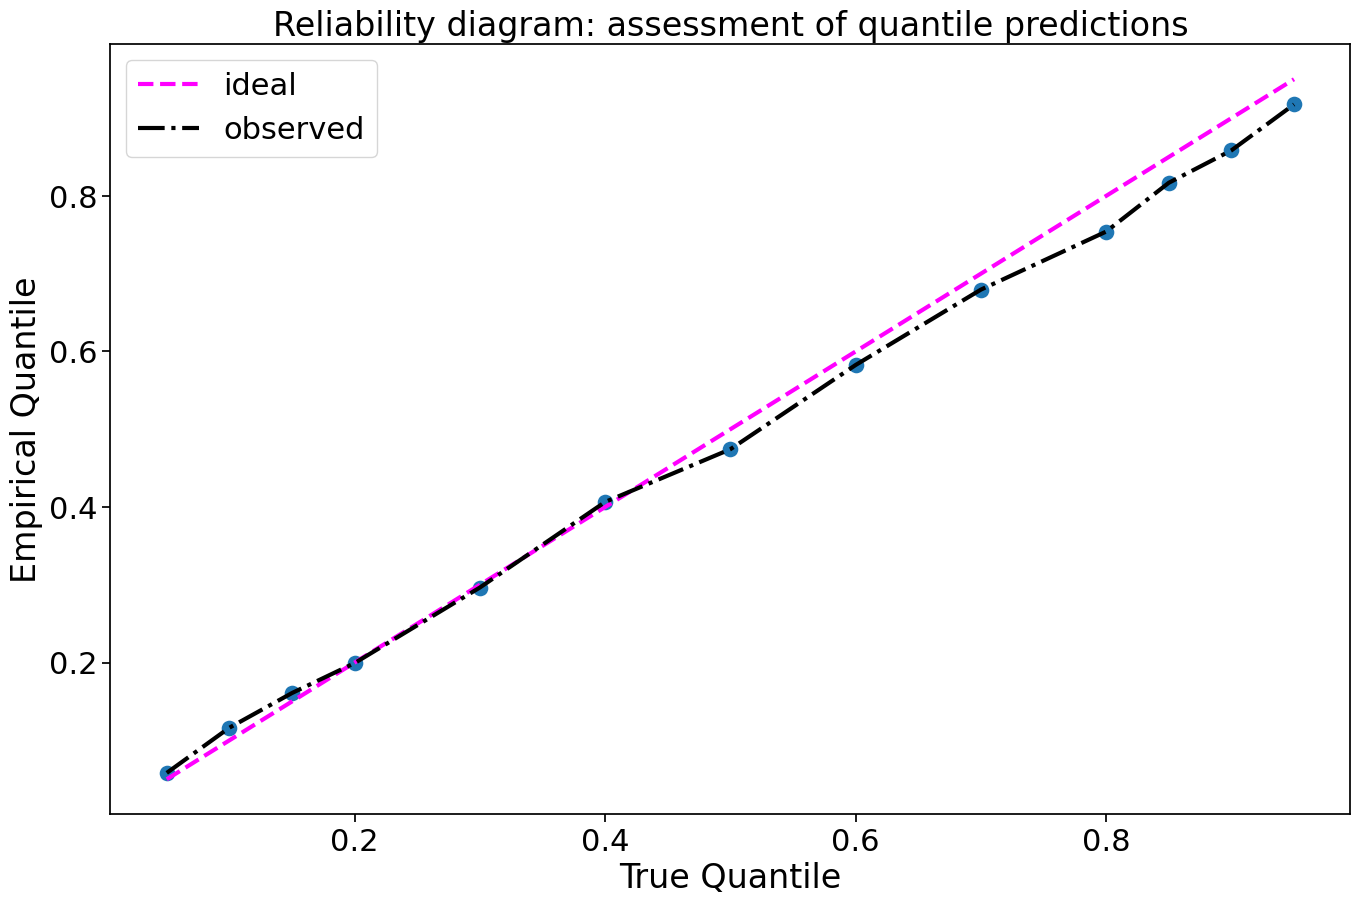

In [42]:
plt.figure(figsize=(16, 10))
sns.set_context("notebook", font_scale=2)
sns.lineplot(x = quantiles, y = quantiles, color = "magenta", linestyle='--', linewidth=3, label = "ideal")
sns.lineplot(x = quantiles, y = empirical_quantiles, color = "black", linestyle = "dashdot", linewidth=3, label = "observed")
sns.scatterplot(x = quantiles, y = empirical_quantiles, marker="o", s = 150)
plt.legend()
plt.xlabel("True Quantile")
plt.ylabel("Empirical Quantile")
_ = plt.title("Reliability diagram: assessment of quantile predictions")

## NGBoost

In [43]:
# NGBoost
ngb = ngboost.NGBoost(Base=learners.default_tree_learner, Dist=distns.Normal, Score=scores.LogScore, natural_gradient=True, verbose=True)
ngb.fit(X_train, y_train)

#predicted mean
ngb_mean_pred = ngb.predict(X_test)

#predicted distribution
ngb_dist_pred = ngb.pred_dist(X_test)

[iter 0] loss=1.5641 val_loss=0.0000 scale=1.0000 norm=1.1069
[iter 100] loss=0.3445 val_loss=0.0000 scale=2.0000 norm=1.0024
[iter 200] loss=-0.7255 val_loss=0.0000 scale=4.0000 norm=1.9891
[iter 300] loss=-2.7209 val_loss=0.0000 scale=4.0000 norm=1.9910
[iter 400] loss=-4.4255 val_loss=0.0000 scale=2.0000 norm=0.8659


In [44]:
ngb_dist_pred

In [45]:
#let's check NGBoost RMSE
mean_squared_error(y_true = y_test, y_pred = ngb_mean_pred, squared=False)

0.0017882085716197653

In [46]:
nll_ngboost = -ngb_dist_pred.logpdf(y_test)
print(f"NLL NGBoost: {nll_ngboost.mean()}")

NLL NGBoost: -4.8884975909367405


In [47]:
nll_ngboost

array([          -5.162,           -5.102,           -4.827, ...,           -4.828,           -5.288,           -4.609])

In [48]:
nll_ngboost.mean()

-4.8884975909367405

In [49]:
ngb_dist_pred.logpdf(y_test.values[0])[0]

5.161688321530734

In [50]:
ngb_dist_pred.params

{'loc': array([           0.477,            0.457,            5.000, ...,            5.000,            0.723,            1.517]),
 'scale': array([           0.002,            0.002,            0.003, ...,            0.003,            0.002,            0.002])}

In [51]:
ngb_dist_pred[0].params

{'loc': 0.47710276090295406, 'scale': 0.0022844303231773374}

In [52]:
y_test.values[0]

0.477

In [53]:
#Compare NLL
np.log(stats.norm.pdf(y_test.values[0], loc = 0.477102760902954, scale = 0.0022844303231773434))

5.1616883215307325

In [54]:
ngb.pred_dist(X_test.iloc[0:1]).params

{'loc': array([           0.477]), 'scale': array([           0.002])}

## Deep Learning Probabilistic Prediction

In [ ]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

In [ ]:
def nll_loss(y, distr):
    return -distr.log_prob(y) 

def model_distribution(params): 
    return tfd.Normal(loc=params[:,0:1], scale=tf.math.softplus(params[:,1:2]))

inputs = layers.Input(shape=((len(X_test.columns),)))

hidden1 = layers.Dense(100, activation = "relu", name = "dense_mean_1")(inputs)
hidden2 = layers.Dense(50, activation = "relu", name = "dense_mean_2")(hidden1)
output_mean = layers.Dense(1, name = "mean_output")(hidden2) #expected mean


hidden1 = layers.Dense(100,activation="relu", name = "dense_sd_1")(inputs)
hidden1 = layers.Dropout(0.1)(hidden1)
hidden2 = layers.Dense(50,activation="relu", name = "dense_sd_2")(hidden1)
hidden2 = layers.Dropout(0.1)(hidden2)
hidden3 = layers.Dense(20,activation="relu", name = "dense_sd_3")(hidden2)
output_sd = layers.Dense(1, name = "sd_output")(hidden3)

mean_sd_layer = layers.Concatenate(name = "mean_sd_concat")([output_mean, output_sd]) 
dist = tfp.layers.DistributionLambda(model_distribution)(mean_sd_layer) 

dist_mean = tfp.layers.DistributionLambda( make_distribution_fn=model_distribution, convert_to_tensor_fn=tfp.distributions.Distribution.mean)(mean_sd_layer)
dist_std = tfp.layers.DistributionLambda( make_distribution_fn=model_distribution, convert_to_tensor_fn=tfp.distributions.Distribution.stddev)(mean_sd_layer)

model_distr = models.Model(inputs=inputs, outputs=dist)
model_distr.compile(optimizers.Adagrad(learning_rate=0.001), loss=nll_loss)

In [ ]:
model_mean = models.Model(inputs=inputs, outputs=dist_mean)
model_sd = models.Model(inputs=inputs, outputs=dist_std)

In [ ]:
model_distr.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_sd_1 (Dense)             (None, 100)          1000        ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 100)          0           ['dense_sd_1[0][0]']             
                                                                                                  
 dense_sd_2 (Dense)             (None, 50)           5050        ['dropout_4[0][0]']              
                                                                                            

In [ ]:
history = model_distr.fit(X_train_scaled, y_train, epochs=150, verbose=1, batch_size = 2**7, validation_data=(X_test_scaled,y_test))

Epoch 1/150
129/129 [==============================] - 1s 5ms/step - loss: 3.3849 - val_loss: 1.9669
Epoch 2/150
129/129 [==============================] - 0s 3ms/step - loss: 1.6898 - val_loss: 1.4486
Epoch 3/150
129/129 [==============================] - 0s 3ms/step - loss: 1.3431 - val_loss: 1.2405
Epoch 4/150
129/129 [==============================] - 0s 3ms/step - loss: 1.1789 - val_loss: 1.1221
Epoch 5/150
129/129 [==============================] - 0s 3ms/step - loss: 1.0867 - val_loss: 1.0431
Epoch 6/150
129/129 [==============================] - 0s 3ms/step - loss: 1.0132 - val_loss: 0.9827
Epoch 7/150
129/129 [==============================] - 0s 3ms/step - loss: 0.9578 - val_loss: 0.9327
Epoch 8/150
129/129 [==============================] - 1s 5ms/step - loss: 0.9213 - val_loss: 0.8907
Epoch 9/150
129/129 [==============================] - 0s 3ms/step - loss: 0.8758 - val_loss: 0.8521
Epoch 10/150
129/129 [==============================] - 0s 3ms/step - loss: 0.8381 - val_lo

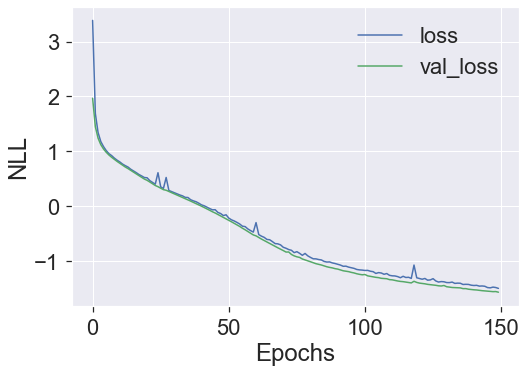

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [ ]:
print(model_distr.evaluate(X_train_scaled,y_train, verbose=0))
print(model_distr.evaluate(X_test_scaled, y_test, verbose=0))

-1.5861364603042603
-1.5662838220596313


In [ ]:
model_distr.evaluate(X_test_scaled[0:1, :], y_test[0:1])

1/1 [==============================] - 0s 23ms/step - loss: -1.4413


-1.4413394927978516

In [ ]:
dl_mean_prediction  = model_mean.predict(X_test_scaled).reshape(-1)
dl_mean_prediction

129/129 [==============================] - 0s 1ms/step


array([           0.519,            0.504,            4.980, ...,            4.985,            0.790,            1.528],
      dtype=float32)

In [ ]:
dl_sd_prediction = model_sd.predict(X_test_scaled).reshape(-1)
dl_sd_prediction

129/129 [==============================] - 0s 2ms/step


array([           0.083,            0.111,            0.035, ...,            0.029,            0.090,            0.088],
      dtype=float32)

In [ ]:
mean_squared_error(y_true = y_test, y_pred=model_mean.predict(X_test_scaled), squared = False)

129/129 [==============================] - 0s 2ms/step


0.051692063386616506

In [ ]:
nll_dl = []
for (true_mean, mean_temp, sd_temp) in zip(y_test, dl_mean_prediction, dl_sd_prediction):
    nll_temp = -stats.norm.logpdf(true_mean, loc = mean_temp, scale = sd_temp)
    nll_dl.append(nll_temp)
nll_dl

[-1.4413396709583297,
 -1.1952603907639219,
 -2.263199196338839,
 -1.0794634932078284,
 -1.5778961230883497,
 -1.3879671398143743,
 -1.3199342201846231,
 -1.601642275037408,
 -2.348106031453567,
 -2.029613970091754,
 -1.652513417600463,
 -1.9112155126114134,
 -1.3897662567606512,
 -1.2100921823521373,
 -1.146035579844304,
 -0.8668075517447528,
 -1.7902033300851308,
 -1.2674097576470595,
 -2.1280568080198576,
 -1.676441317845125,
 -2.0212236644724486,
 -2.17275404940305,
 -1.1516676548915634,
 -1.9642443587119094,
 -1.9061738692330976,
 -1.59136679528242,
 -1.394788298772261,
 -3.142240939754952,
 -1.7241871252936034,
 -1.8238622599295031,
 -2.2615902975677273,
 -1.4716808630046625,
 -2.410962851318883,
 -2.261983423162271,
 -1.6747766773422272,
 -0.41991023670342753,
 -1.990497607940209,
 -1.4133816281543492,
 -2.0980354875804683,
 -2.104786217041422,
 -1.291177255722156,
 -1.2080218175659145,
 -2.0217270677284893,
 -1.7827644973194836,
 -1.1747303905392505,
 -1.4311426213842078,
 -2.2

In [ ]:
np.mean(nll_dl)

-1.5662839258531804

In [ ]:
comparison_df = pd.DataFrame({'nll_ngboost': nll_ngboost, 'nll_dl': nll_dl, 
                               'true': y_test, 'mean_dl': dl_mean_prediction, 'mean_ngboost': ngb_mean_pred, 
                               'sd_dl': dl_sd_prediction, 'sd_ngboost': ngb_dist_pred.params["scale"]
                              }).reset_index(drop=True)
comparison_df

,nll_ngboost,nll_dl,true,mean_dl,mean_ngboost,sd_dl,sd_ngboost
0,-5.16169,-1.44134,0.47700,0.51942,0.47710,0.08278,0.00228
1,-5.10186,-1.19526,0.45800,0.50447,0.45744,0.11052,0.00236
2,-4.82721,-2.26320,5.00001,4.97988,4.99987,0.03525,0.00319
3,-5.25176,-1.07946,2.18600,2.12455,2.18643,0.11850,0.00204
4,-5.26177,-1.57790,2.78000,2.81539,2.78009,0.07328,0.00207
...,...,...,...,...,...,...,...
4123,-2.40007,-1.72262,2.63300,2.66618,2.63790,0.06164,0.00204
4124,-4.03695,-0.97940,2.66800,2.66953,2.66478,0.14981,0.00204
4125,-4.82793,-2.48072,5.00001,4.98520,4.99995,0.02941,0.00319
4126,-5.28774,-1.21628,0.72300,0.78974,0.72338,0.08956,0.00198


In [ ]:
def plot_predicted_distribution(index, figsize = (25, 7)):
    row = comparison_df.iloc[index]
    
    true_value = row["true"]
    loc1 = row["mean_dl"]
    loc2 = row["mean_ngboost"]
    
    scale1 = row["sd_dl"]
    scale2 = row["sd_ngboost"]
    
    
    nll_dl = -stats.norm.logpdf(true_value, loc = loc1, scale = scale1)
    nll_ngboost = -stats.norm.logpdf(true_value, loc = loc2, scale = scale2)
    ############################################################################
    x = np.linspace(min(y_test), max(y_test), 100)

    colors = ["#348ABD", "#A60628"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
    fig.suptitle('Comparison between DL and NGBoost')

    pdf1 = stats.norm.pdf(x, loc = loc1, scale=scale1)
    ax1.plot(x, pdf1, lw=3, color=colors[0], label=f"$\mu$={np.round(loc1,4)}, $\sigma$={np.round(scale1, 4)}, \ntrue obs = {true_value}")
    ax1.fill_between(x, stats.norm.pdf(x, loc = loc1, scale = scale1), color=colors[0], alpha=.33)
    ax1.legend()
    ax1.set_ylabel("PDF")
    #ax1.set_xlabel("$x$")
    ax1.set_title(f"DL: NLL = {np.round(nll_dl, 2)}")
    ax1.set_xlim(true_value/2, true_value * 2)
    ax1.vlines(true_value, 0, max(pdf1), 'g', linestyle = "--", label='true label')

    pdf2 = stats.norm.pdf(x, loc = loc2, scale=scale2)
    ax2.plot(x, pdf2, lw=3, color=colors[1], label=f"$\mu$={np.round(loc2, 4)}, $\sigma$={np.round(scale2, 4)}, \ntrue obs = {true_value}")
    ax2.fill_between(x, stats.norm.pdf(x, loc = loc2, scale = scale2), color=colors[1], alpha=.33)
    ax2.legend()
    ax2.set_ylabel("PDF")
    #ax2.set_xlabel("$x$")
    ax2.set_title(f"NGBoost: NLL = {np.round(nll_ngboost,2)}")
    ax2.set_xlim(true_value/2, true_value * 2)
    ax2.vlines(true_value, 0, max(pdf2), 'g', linestyle = "--", label='true label')
    
    
    
    ax1.title.set_fontsize(30)
    ax1.xaxis.label.set_fontsize(20)
    ax1.yaxis.label.set_fontsize(20)
    
    ax2.title.set_fontsize(30)
    ax2.xaxis.label.set_fontsize(20)
    ax2.yaxis.label.set_fontsize(20)
    
    plt.show()

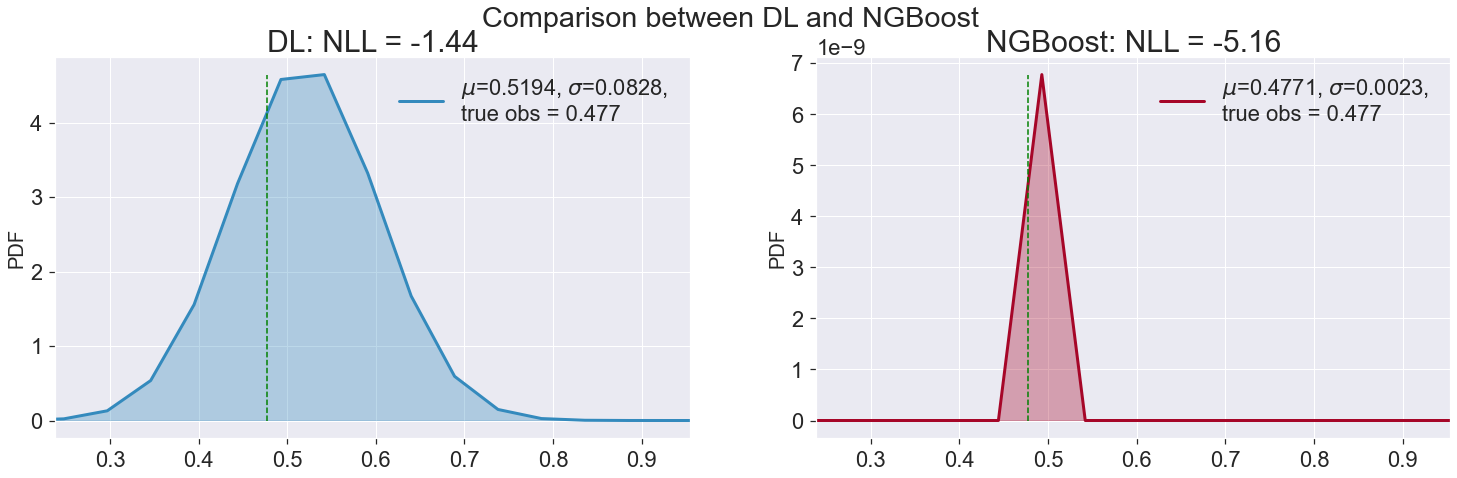

In [ ]:
plot_predicted_distribution(0)

In [ ]:
comparison_df.groupby(lambda x: True).agg({'nll_ngboost': ['mean', 'min', 'max'], 'nll_dl': ['mean', 'min', 'max'], 'true': ['min', 'mean', 'max']})

nll_ngboost                    nll_dl                      true          \
            mean      min     max     mean      min      max     min    mean   
True    -4.88850 -5.32617 9.32773 -1.56628 -3.59539 38.45793 0.14999 2.05500   

              
         max  
True 5.00001

## Validity for Probabilistic Models

In [ ]:
#check if the true value is within the predictive interval

validity_pd = pd.DataFrame()
for interval in [0.6, 0.7, 0.8, 0.9]:
    #calculate density concentration 
    interval = np.round(interval, 1)
    validity_ngboost = stats.norm.interval(interval, loc = ngb_mean_pred, scale = ngb_dist_pred.params["scale"])
    validity = np.mean((validity_ngboost[0] > y_test) | (y_test > validity_ngboost[1]))
    validity_pd = pd.concat([validity_pd, pd.DataFrame({'estimator': ['NGBoost'], 'interval': [interval], 'validity': [validity]})])  

for interval in [0.6, 0.7, 0.8, 0.9]:
    validity_dl = stats.norm.interval(interval, loc = dl_mean_prediction, scale = dl_sd_prediction)
    validity = np.mean((validity_dl[0] > y_test) | (y_test > validity_dl[1]))
    validity_pd = pd.concat([validity_pd, pd.DataFrame({'estimator': ['DL'], 'interval': [interval], 'validity': [validity]})])  
    
for quantile in [(0.2, 0.8), (0.15, 0.85), (0.1, 0.9), (0.05, 0.95)]:
    interval = np.round(quantile[1] - quantile[0], 1)
    validity = np.mean((quantile_predictions[quantile[0]] > y_test) | (y_test > quantile_predictions[quantile[1]]))
    validity_pd = pd.concat([validity_pd, pd.DataFrame({'estimator': ['Lightgbm Quantile Regression'], 'interval': [interval], 'validity': [validity]})]) 
    
validity_pd = validity_pd.reset_index(drop=True).sort_values(by="interval").set_index(["estimator", "interval"])
validity_pd

,,validity
estimator,interval,
NGBoost,0.60000,0.25024
DL,0.60000,0.19864
Lightgbm Quantile Regression,0.60000,0.42975
NGBoost,0.70000,0.18556
DL,0.70000,0.13324
Lightgbm Quantile Regression,0.70000,0.34375
NGBoost,0.80000,0.11749
DL,0.80000,0.08285
Lightgbm Quantile Regression,0.80000,0.24952


In [ ]:
validity_pd.reset_index()

,estimator,interval,validity
0,NGBoost,0.60000,0.25024
1,DL,0.60000,0.19864
2,Lightgbm Quantile Regression,0.60000,0.42975
3,NGBoost,0.70000,0.18556
4,DL,0.70000,0.13324
5,Lightgbm Quantile Regression,0.70000,0.34375
6,NGBoost,0.80000,0.11749
7,DL,0.80000,0.08285
8,Lightgbm Quantile Regression,0.80000,0.24952
9,NGBoost,0.90000,0.05208


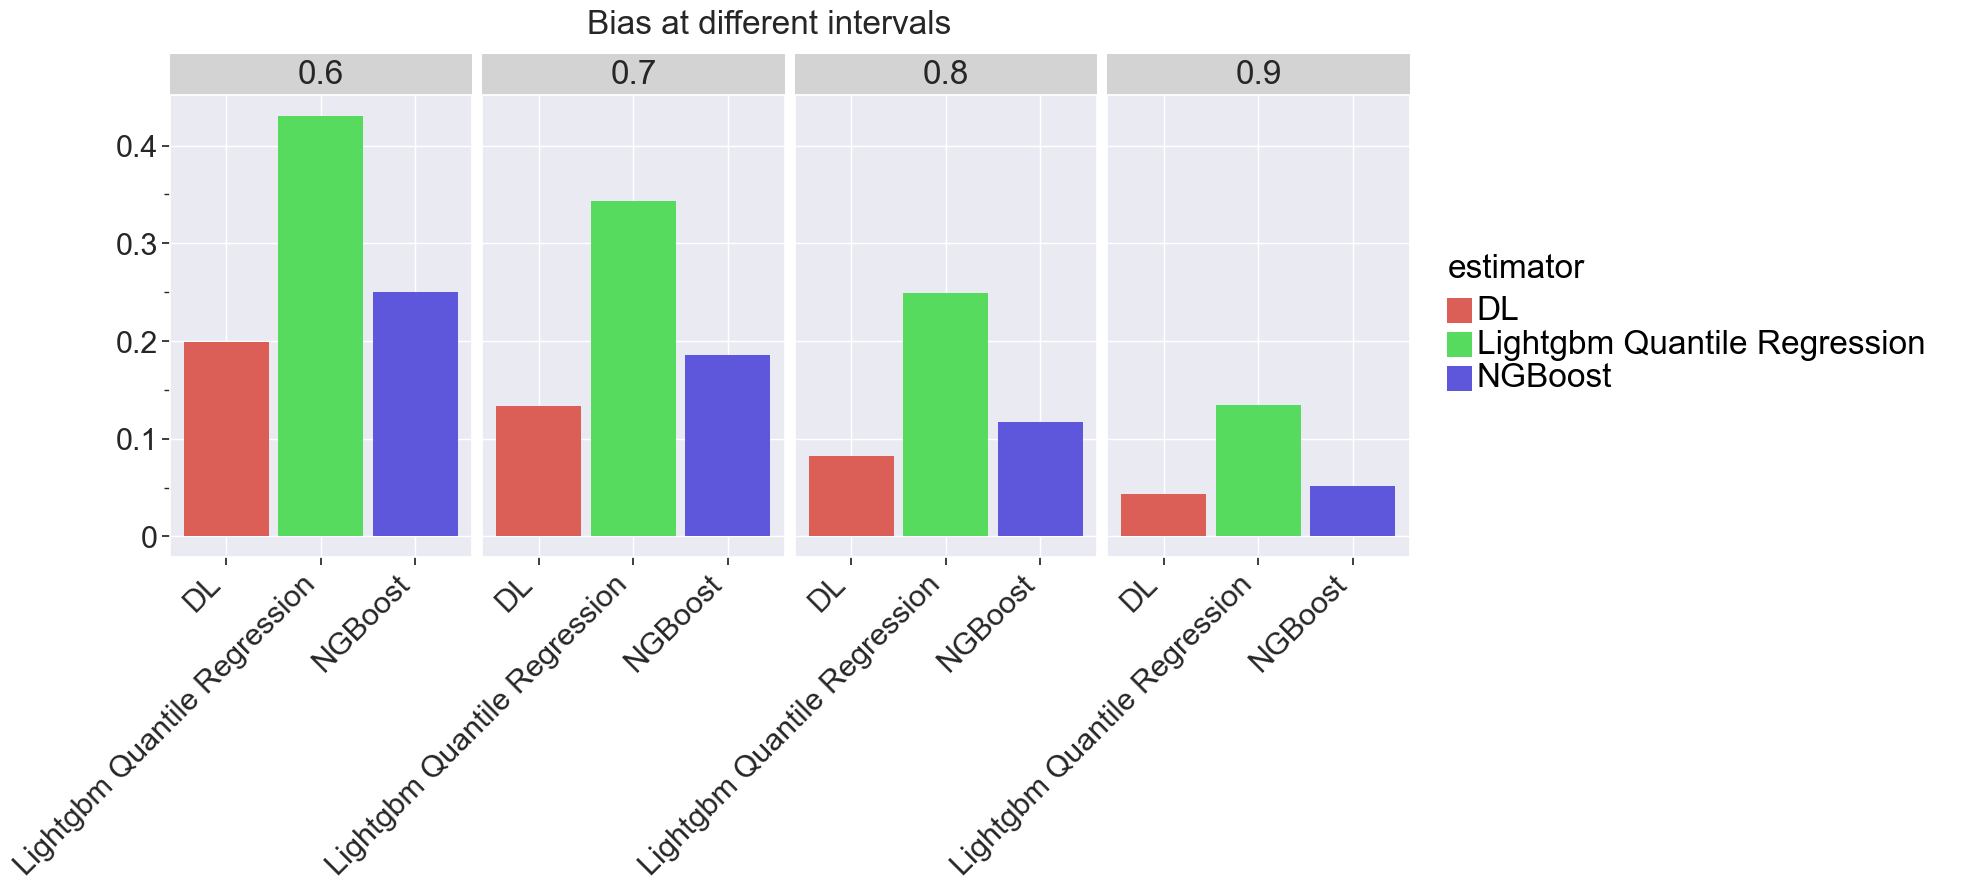

<ggplot: (157388446639)>

In [ ]:
ggplot(aes("estimator", "validity", fill = "estimator"), validity_pd.reset_index()) + geom_bar(stat = "identity") + facet_grid(".~interval") + \
xlab("") + ylab("") + ggtitle("Bias at different intervals") + theme_seaborn(font_scale = 2) +  \
theme(figure_size=(16, 6), axis_text_x=element_text(rotation=45, hjust=1))

## Sharpness - Concentration of Probabilities

In [ ]:
sharpness_pd = pd.DataFrame()
for interval in [0.6, 0.7, 0.8, 0.9]:
    #calculate density concentration 
    interval = np.round(interval, 1)
    sharpness_ngboost = stats.norm.interval(interval, loc = ngb_mean_pred, scale = ngb_dist_pred.params["scale"])
    value = np.mean(sharpness_ngboost[1] - sharpness_ngboost[0])
    sharpness_pd = pd.concat([sharpness_pd, pd.DataFrame({'estimator': ['NGBoost'], 'interval': [interval], 'value': [value]})])  

for interval in [0.6, 0.7, 0.8, 0.9]:
    sharpness_dl = stats.norm.interval(interval, loc = dl_mean_prediction, scale = dl_sd_prediction)
    value = np.mean(sharpness_dl[1] - sharpness_dl[0])
    sharpness_pd = pd.concat([sharpness_pd, pd.DataFrame({'estimator': ['DL'], 'interval': [interval], 'value': [value]})])  
    
for quantile in [(0.2, 0.8), (0.15, 0.85), (0.1, 0.9), (0.05, 0.95)]:
    interval = np.round(quantile[1] - quantile[0], 1)
    value = (quantile_predictions[quantile[1]] - quantile_predictions[quantile[0]]).mean()
    sharpness_pd = pd.concat([sharpness_pd, pd.DataFrame({'estimator': ['Lightgbm Quantile Regression'], 'interval': [interval], 'value': [value]})]) 

sharpness_pd = sharpness_pd.reset_index(drop=True).sort_values(by="interval").set_index(["estimator", "interval"])
sharpness_pd

,,value
estimator,interval,
NGBoost,0.60000,0.00380
DL,0.60000,0.11672
Lightgbm Quantile Regression,0.60000,0.09588
NGBoost,0.70000,0.00468
DL,0.70000,0.14373
Lightgbm Quantile Regression,0.70000,0.21447
NGBoost,0.80000,0.00579
DL,0.80000,0.17773
Lightgbm Quantile Regression,0.80000,0.47557


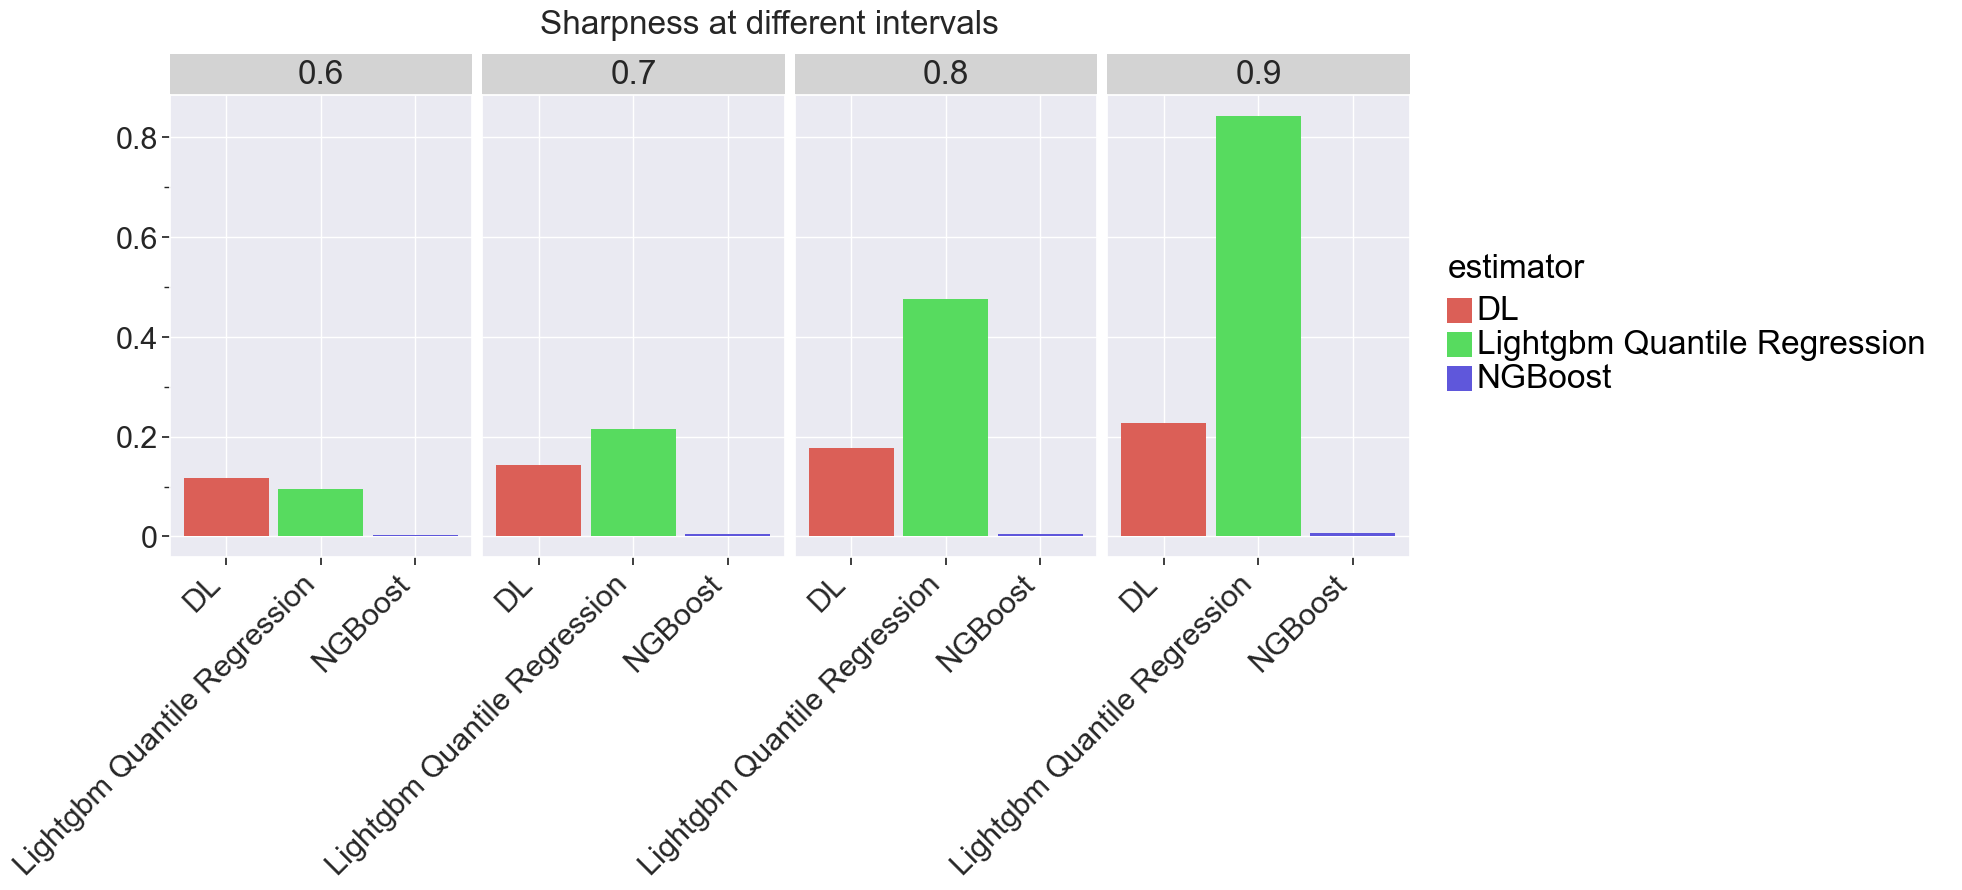

<ggplot: (157396690661)>

In [ ]:
ggplot(aes("estimator", "value", fill = "estimator"), sharpness_pd.reset_index()) + geom_bar(stat = "identity") + facet_grid(".~interval", scales = "free") + \
xlab("") + ylab("") + ggtitle("Sharpness at different intervals") + theme_seaborn(font_scale = 2) +  \
theme(figure_size=(16, 6), axis_text_x=element_text(rotation=45, hjust=1))

## Continous Ranked Probabilistic Score (CRPS)

In [ ]:
comparison_df["crps_ngboost"] = comparison_df.apply(lambda x: ps.crps_gaussian(x["true"], mu = x["mean_ngboost"], sig = x["sd_ngboost"]), axis = 1)
comparison_df["crps_dl"] = comparison_df.apply(lambda x: ps.crps_gaussian(x["true"], mu = x["mean_dl"], sig = x["sd_dl"]), axis = 1)

In [ ]:
comparison_df

,nll_ngboost,nll_dl,true,mean_dl,mean_ngboost,sd_dl,sd_ngboost,crps_ngboost,crps_dl
0,-5.16169,-1.44134,0.47700,0.51942,0.47710,0.08278,0.00228,0.00054,0.02783
1,-5.10186,-1.19526,0.45800,0.50447,0.45744,0.11052,0.00236,0.00060,0.03351
2,-4.82721,-2.26320,5.00001,4.97988,4.99987,0.03525,0.00319,0.00075,0.01270
3,-5.25176,-1.07946,2.18600,2.12455,2.18643,0.11850,0.00204,0.00051,0.04013
4,-5.26177,-1.57790,2.78000,2.81539,2.78009,0.07328,0.00207,0.00048,0.02381
...,...,...,...,...,...,...,...,...,...
4123,-2.40007,-1.72262,2.63300,2.66618,2.63790,0.06164,0.00204,0.00376,0.02136
4124,-4.03695,-0.97940,2.66800,2.66953,2.66478,0.14981,0.00204,0.00216,0.03502
4125,-4.82793,-2.48072,5.00001,4.98520,4.99995,0.02941,0.00319,0.00075,0.00979
4126,-5.28774,-1.21628,0.72300,0.78974,0.72338,0.08956,0.00198,0.00049,0.03990


In [ ]:
crps_ngboost = ps.crps_gaussian(y_test, ngb_dist_pred.params["loc"], ngb_dist_pred.params["scale"]).mean()
crps_dl = ps.crps_gaussian(y_test, dl_mean_prediction, dl_sd_prediction).mean()

(crps_ngboost, crps_dl)

(0.0009875382132853662, 0.026605031737895427)

In [ ]:
print(f"CRPS NGBoost: {comparison_df['crps_ngboost'].mean().round(4)}")
print(f"CRPS DL: {comparison_df['crps_dl'].mean().round(4)}")

CRPS NGBoost: 0.001
CRPS DL: 0.0266
